#  Swarm Intelligence and Simulated Evolution - Univariate (1D) Case


Your task here is to understand and employ a python code package that implements PSO.

This code
bundle provided will be able to take any scalar valued objective function $J(\mathbf{x})$ of and a pre-defined search
region $S_x$ and then return a ``good” candidate for the global minimum point of that objective
function (within that search space).
Here you will use the PSO package to deal with univariate functions. This means your swarm
particles/agents $\mathbf{x}_n$ will have only one dimension, and they will be searching along the x-axis.



The version of PSO to be used is provided to you as a Python file called assignment_pso.py
containing all the functions that you have to import and use

Notably, each randomly generated objective function provided by the code is restricted to a different interval on the x-axis. The plots in Fig.1 were gen-
erated by first specifying a set of points on the x-axis using numpy as np.linspace(x_min, x_max)
and then evaluating the objective function at these points. Finally we plot these by mean of the
Python plotting package matplotlib.


First you need to mount your own Google Drive disk to Colab, and upload the file assignment_pso.py so that Colab can import it in the second cell below.

In [ ]:
#Mount personal drive and move into main directory
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('drive')
os.chdir('MyDrive')
os.chdir('AI_for_IA_2023/Assignment5')
os.listdir()  #list the files of the folder from where Colab will read and write files


Mounted at /content/drive


['assignment_pso.py',
 'noisy_xor.csv',
 '__pycache__',
 'animation_demo_example.mp4',
 'TASK_A_PSO_multivariate_for_ANN_v230925.ipynb']

You also  need to import standard tools as follows

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import assignment_pso as ass_pso

# Generate and show random univariate function to minimize

200


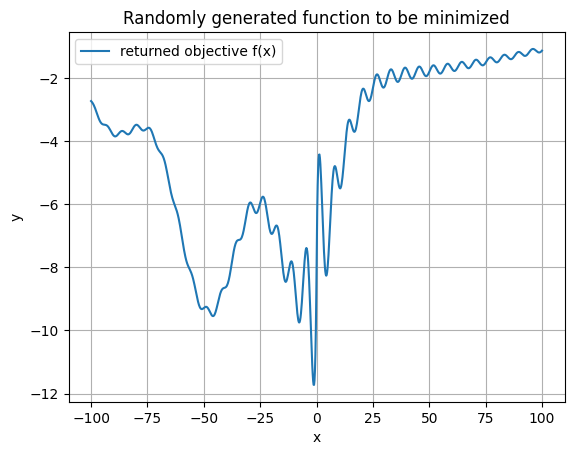

In [8]:
# Specify interval bounds
x_min = np.array(-100)
x_max = np.array(100)

# call and recieve a function.
# Every time you call this below, results in you getting a completly new funcion
obj_f = ass_pso.generate_an_objective_function(x_min=x_min, x_max=x_max)

# plotting recieved objective function that we would like to find min of later
x = np.linspace(x_min, x_max, 1000)
z = obj_f(x)

plt.plot(x,z, label='returned objective f(x)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Randomly generated function to be minimized')
plt.grid()
plt.legend()

### Code defining the  Python class Particle for 1D particles

In [13]:
class Particle_1D():
    def __init__(self, x_min, x_max, v_max, particle_id, objective_function, c1, c2):

        self.id = particle_id
        self.c1 = c1
        self.c2 = c2

        self.x_min = x_min
        self.x_max = x_max
        self.v_max = v_max

        self.x = np.random.uniform(low = x_min, high=x_max, size=len(x_min))

        self.objective_function = objective_function

        self.fx = self.objective_function(self.x) #evaluate obj functon at current position

        self.v_next = 0.01*np.random.randn(*x_min.shape)

        self.personal_best_x = self.x # personal best position of particle in  ust x_0 for paticle initally
        self.personal_best_fx = self.fx # personal best of particle in the begining is just f(x) of x_0 for paticle  initally

        self.trajectory = []
        self.trajectory.append((self.x, self.fx))


    def get_particle_info_array(self):
        # Return array with
        # [x, f(x), v_next, x_personal_best, f(x_personal_best)]
        particle_info_array = [self.id, self.x, self.fx, self.v_next, self.personal_best_x, self.personal_best_fx]
        return np.array(particle_info_array, dtype=np.double)



    def step(self, global_best_x):
        # update v_next
        #r1=0.7
        #r2=0.3

        r1= np.random.uniform(size=1)
        r2 = np.random.uniform(size=1)


        cognitive_influence = self.c1 * r1 * (self.personal_best_x - self.x)
        social_influence = self.c2 * r2 * (global_best_x - self.x)
        self.v_next = self.v_next + cognitive_influence + social_influence

        # Cap v_next if it gets to big
        if np.abs(self.v_next) > self.v_max:
            self.v_next = self.v_max * np.sign(self.v_next)
        #print(f'New v_max {self.v_next} \n')


        # update x
        self.x = self.x + self.v_next
        # cap at search boundray
        if self.x >self.x_max:
            self.x = self.x_max

        if self.x < self.x_min:
            self.x = self.x_min

        # evaluate f(x)
        self.fx = self.objective_function(self.x)

        # update personal_best_x if case

        if self.fx < self.personal_best_fx:
            #print(f'particle {self.id}  has achieved personal best')
            self.personal_best_x = self.x
            self.personal_best_fx = self.fx

        # append current pos and eval to trajectory
        self.trajectory.append((self.x, self.fx))


**Problem A1**

Try to play around with various combinations of different parameter values and use the animation functions to get a better intuitive feel for how these parameter settings influence the swarm behavior. You should save results from at least two runs, in order to be shown in your report/presentation.

### Code defining the Python class Swarm for 1D particles



In [14]:
# BASIC ASSIGNMENT (1D)
class Swarm_1D():

    def __init__(self, objective_function, N_particles, x_min, x_max, v_max, c1, c2 ):

        self.objective_function = objective_function
        self.nr_particles = N_particles
        self.x_min = x_min
        self.x_max = x_max
        self.v_max = v_max
        self.step_i = 0 # internal step counter
        self.c1 = c1
        self.c2 = c2

        # Init N paritcles in swarm
        self.swarm = []
        for i in range(self.nr_particles):
            p = Particle_1D(x_min=x_min, x_max=x_max, v_max=v_max, particle_id=i, objective_function=self.objective_function, c1=c1, c2=c2)
            self.swarm.append(p)

        self.global_best_x, self.global_best_fx= self.get_current_best_x_and_fx()

        print(f'Current global best x: {self.global_best_x} - f(x): {self.global_best_fx}')

    def visualize_swarm(self, figsize=[10,4]): # majnotes: mention figsize param.
        x = np.linspace(x_min, x_max, 1000)
        y = self.objective_function(x)

        plt.figure(figsize=figsize)
        plt.grid()
        plt.plot(x,y)
        plt.xlim([self.x_min, self.x_max])
        plt.title(f'Step: {self.step_i}')

        for particle in self.swarm:
            plt.scatter(particle.x, particle.fx, label=particle.id)
            plt.text(particle.x, particle.fx*(1 + 0.1), particle.id , fontsize=12)


        plt.plot(self.global_best_x, self.global_best_fx, marker='X',  markersize=20)
        plt.text(self.global_best_x + 2, self.global_best_fx - 1, 'Global Best' , fontsize=15)
        plt.xlabel('x')
        plt.ylabel('y=f(x)')
        plt.show()


    def get_swarm_info_array(self):
        swarm_info_array = []
        for particle in self.swarm:
            swarm_info_array.append(particle.get_particle_info_array())

        return np.array(swarm_info_array)


    def get_current_best_x_and_fx(self):
        '''return the global best position x_best and the value of the objective function value at posistion x_best '''

        s = self.get_swarm_info_array()

        ss = s[s[:,2].argsort(), :]

        current_best_x = ss[0,1]
        current_best_fx = ss[0,2]

        return current_best_x, current_best_fx


    def step( self):
        # for all particles take a step
        for particle in self.swarm:
            particle.step(global_best_x=self.global_best_x)


        # get and set current best and logic it
        current_best_x, current_best_fx = self.get_current_best_x_and_fx()

        if current_best_fx < self.global_best_fx:
            print(f'New Global Best has been achieved - x: {current_best_x}  f(x): {current_best_fx}')

            self.global_best_x = current_best_x
            self.global_best_fx = current_best_fx


        self.step_i +=1 # add 1 to step counter


    def run(self, nr_steps):
        for i in range(nr_steps):
            self.step()


    def plot_swarm_trajectory_graph(self, figsize=[10,4]):

        t = np.arange(self.step_i+1)

        plt.figure(figsize=figsize)

        for particle in self.swarm:
            x_and_fx = np.array(particle.trajectory)

            print()

            plt.plot(t, x_and_fx[:,0])

        plt.hlines(y=self.global_best_x, xmin=-5, xmax=self.step_i,linestyles='--', color='orange', linewidth=10)

        plt.xlabel('iteration step')
        plt.ylabel('search space x')
        plt.grid()


### A demo example how the code snippets aboove should be combined: Step 0 (start)

In [15]:
x_min = np.array([-2000])   ## assume numpy scalers as input.
x_max = np.array([1000])
obj_f = ass_pso.generate_an_objective_function(x_min=x_min, x_max=x_max)

v_max = np.array(2)

c1 = 1.0
c2 = 1.0

N_particles = 20

# Init swarm
s = Swarm_1D(objective_function=obj_f, N_particles=N_particles, x_min=x_min, x_max=x_max, v_max=v_max, c1=c1, c2=c2)

# Viz
s.visualize_swarm(figsize=[10,5])

[3000]


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (6,) + inhomogeneous part.

### Example run for 1000 steps, and the resulting printouts

In [ ]:
s.run(nr_steps=1000) # run swarm for 1000 steps

<ipython-input-5-bf7b93611e61>:31: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  return np.array(particle_info_array, dtype=np.double)


New Global Best has been achieved - x: -1774.9484363009974  f(x): -3.672170430877138
New Global Best has been achieved - x: -1774.946853729183  f(x): -3.6723458525584856
New Global Best has been achieved - x: -1774.9452711573686  f(x): -3.6725212922684816
New Global Best has been achieved - x: -1774.9436885855541  f(x): -3.6726967499844196
New Global Best has been achieved - x: -1774.9421060137397  f(x): -3.672872225683607
New Global Best has been achieved - x: -1774.9405234419253  f(x): -3.67304771934335
New Global Best has been achieved - x: -1774.9389408701109  f(x): -3.673223230940965
New Global Best has been achieved - x: -1774.9373582982964  f(x): -3.6733987604537703
New Global Best has been achieved - x: -1774.935775726482  f(x): -3.6735743078590914
New Global Best has been achieved - x: -0.7619746783263572  f(x): -4.35077510706769
New Global Best has been achieved - x: -0.8675949049183629  f(x): -4.450485682681558
New Global Best has been achieved - x: -1766.9341931546676  f(x)

### Visualization of the swarm after the last iteration

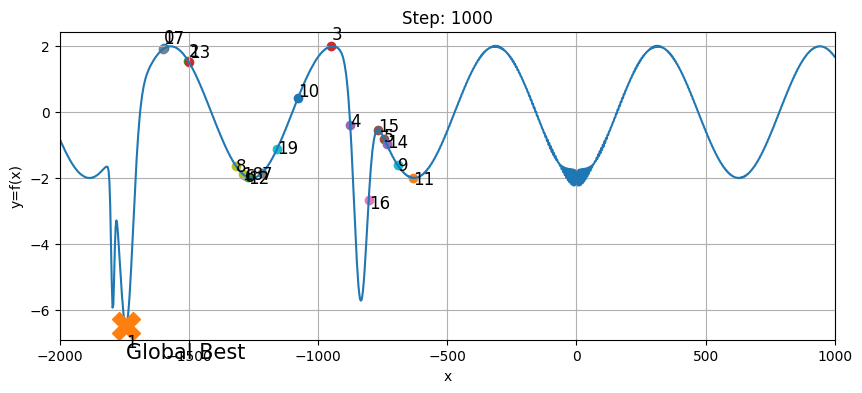

In [ ]:
s.visualize_swarm()

### A second example

[3000]
Current global best x: -602.5840840485014 - f(x): -4.201395716652295


<ipython-input-5-bf7b93611e61>:31: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  return np.array(particle_info_array, dtype=np.double)


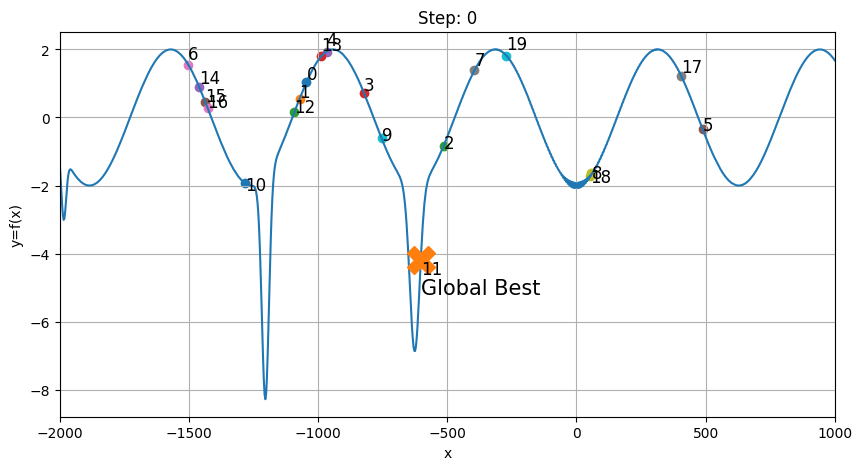

In [ ]:
x_min = np.array([-2000])   ## assume numpy scalers as input.
x_max = np.array([1000])
obj_f = ass_pso.generate_an_objective_function(x_min=x_min, x_max=x_max)

v_max = np.array(2)

c1 = 1
c2 = 14.

N_particles = 20

# Init swarm
s2 = Swarm_1D(objective_function=obj_f, N_particles=N_particles, x_min=x_min, x_max=x_max, v_max=v_max, c1=c1, c2=c2)

# Viz
s2.visualize_swarm(figsize=[10,5]);

### Produce a mp4 animation video of your PSO steps
The following code will produce and save an video file in mp4 format, which will be called animation_demo_example. You can download it from your Google Drive as it has been saved there.

Remark.
You can ignore the warnings printed out while runing this cell.

Generating 1D PSO animation.....
0


<ipython-input-5-bf7b93611e61>:31: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  return np.array(particle_info_array, dtype=np.double)


0
New Global Best has been achieved - x: -602.6418500559867  f(x): -4.210421983986074
1
New Global Best has been achieved - x: -602.708696898136  f(x): -4.220887272299212
2
New Global Best has been achieved - x: -602.7755437402855  f(x): -4.231373110795323
3
New Global Best has been achieved - x: -602.8423905824349  f(x): -4.241878419134068
4
New Global Best has been achieved - x: -602.9092374245843  f(x): -4.252402089671983
5
New Global Best has been achieved - x: -602.9760842667337  f(x): -4.262942991586315
6
New Global Best has been achieved - x: -603.0429311088831  f(x): -4.273499975095576
7
New Global Best has been achieved - x: -603.1097779510325  f(x): -4.2840718757579435
8
New Global Best has been achieved - x: -603.1766247931819  f(x): -4.294657518828355
9
New Global Best has been achieved - x: -603.2434716353313  f(x): -4.305255723654781
10
New Global Best has been achieved - x: -603.3103184774807  f(x): -4.315865308094106
11
New Global Best has been achieved - x: -603.377165

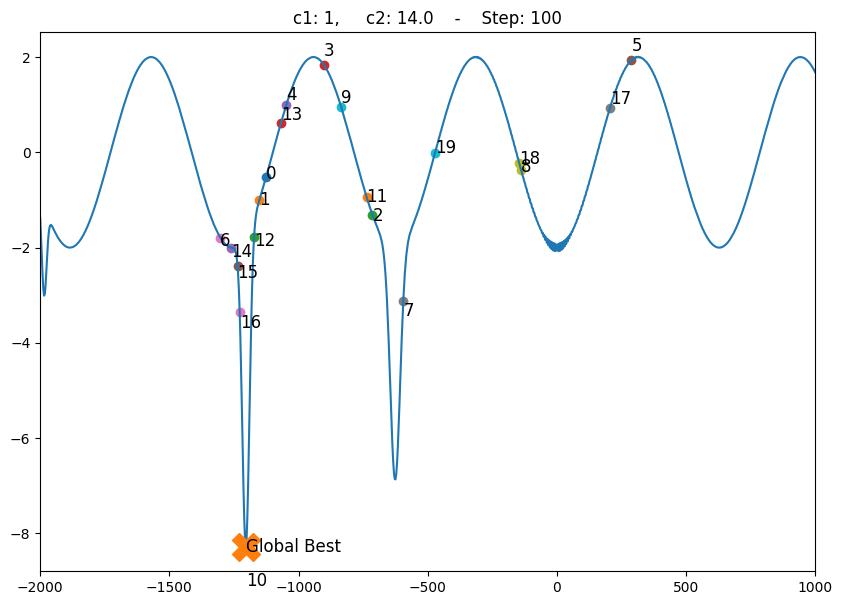

In [ ]:
no_of_iterations=100
ass_pso.generate_1D_PSO_animation(s2, no_of_iterations, 'animation_demo_example');

# Now what?:
Once you have altered the Particle/Swarm classes accordingly to get at a functional PSO algorithm, continue by answering the problems in the assignment document.